## PINN for a backwater curve (minimal)

Solve the gradually varied flow ODE for a trapezoidal channel with a Physics-Informed Neural Network (PINN), and compare against a standard numerical IVP solve.

Coordinate convention (matches the reference notebook):
- `x = 0` at downstream, `x` increases upstream
- Bed rises upstream: $z_{bed}(x)=z_{bed}(0)+S_0 x$ with $S_0>0$

Backwater ODE (subcritical):
$$\frac{dh}{dx} = \frac{S_f(h)-S_0}{1-Fr(h)^2}$$

Boundary condition for subcritical flow: $h(0)=h_{ds}$.

In [145]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Setup device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Note: If you encounter font rendering errors with matplotlib plots,
# uncomment the line below to force CPU usage (workaround for Windows font issues)
# device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cpu


### Define Channel Parameters and Hydraulic Functions

In [ ]:
# Channel parameters (match the reference backwater notebook)
L = 500.0           # Channel length (m)
S0 = 0.001          # Bed slope magnitude (m/m); bed rises upstream in +x
n = 0.05            # Manning coefficient (s/m^(1/3))
m = 1.0             # Side slope (H:V)
b = 10.0            # Bottom width (m)
Q = 5.0            # Discharge (m^3/s)
g = 9.81            # Gravity (m/s^2)
h_downstream = 0.7  # Downstream boundary condition at x=0 (depth, m)

def compute_area(h):
    """Cross-sectional area for trapezoidal channel."""
    return h * (b + m * h)

def compute_wetted_perimeter(h):
    """Wetted perimeter for trapezoidal channel."""
    return b + 2.0 * h * np.sqrt(1.0 + m**2)

def compute_hydraulic_radius(h):
    """Hydraulic radius."""
    A = compute_area(h)
    P = compute_wetted_perimeter(h)
    return A / P

def compute_top_width(h):
    """Top width."""
    return b + 2.0 * m * h

def compute_friction_slope(h):
    """Friction slope from Manning's equation."""
    A = compute_area(h)
    R = compute_hydraulic_radius(h)
    return (n**2 * Q**2) / (A**2 * R**(4.0 / 3.0))

def compute_froude_number(h):
    """Froude number."""
    A = compute_area(h)
    T = compute_top_width(h)
    D = A / T
    V = Q / A
    return V / np.sqrt(g * D)

def backwater_rhs(h):
    """Right-hand side for x increasing upstream: dh/dx = (Sf - S0) / (1 - Fr^2)."""
    Sf = compute_friction_slope(h)
    Fr = compute_froude_number(h)
    denom = 1.0 - Fr**2
    if np.isclose(denom, 0.0):
        denom = 1e-8
    return (Sf - S0) / denom

# Normal and critical depths (for reference)
def solve_depth(func, y_low=1e-3, y_high=50.0, tol=1e-8, max_iter=200):
    f_low = func(y_low)
    f_high = func(y_high)
    if f_low * f_high > 0:
        return np.nan
    for _ in range(max_iter):
        y_mid = 0.5 * (y_low + y_high)
        f_mid = func(y_mid)
        if abs(f_mid) < tol:
            return y_mid
        if f_low * f_mid < 0:
            y_high, f_high = y_mid, f_mid
        else:
            y_low, f_low = y_mid, f_mid
    return y_mid

h_normal = solve_depth(lambda h: compute_friction_slope(h) - S0)
h_critical = solve_depth(lambda h: compute_froude_number(h) - 1.0)

print("Channel parameters:")
print(f"  Length L = {L} m")
print(f"  Bed slope S0 = {S0} ({S0*100}%)")
print(f"  Manning n = {n:.4f} s/m^(1/3)")
print(f"  Side slope m = {m} H:V")
print(f"  Bottom width b = {b} m")
print(f"  Discharge Q = {Q} m³/s")
print(f"  Normal depth h_n ≈ {h_normal:.3f} m")
print(f"  Critical depth h_c ≈ {h_critical:.3f} m")
print(f"  Downstream depth h(0) = {h_downstream} m")
print(f"  Downstream Fr ≈ {compute_froude_number(h_downstream):.3f}")

Channel parameters:
  Length L = 500.0 m
  Bed slope S0 = 0.001 (0.1%)
  Manning n = 0.0500 s/m^(1/3)
  Side slope m = 1.0 H:V
  Bottom width b = 10.0 m
  Discharge Q = 20.0 m³/s
  Normal depth h_n ≈ 1.990 m
  Critical depth h_c ≈ 0.723 m
  Downstream depth h(0) = 0.7 m
  Downstream Fr ≈ 1.052


### Reference Solution using Numerical Integration

Solve the backwater equation using initial value problem (IVP) with downstream BC for subcritical flow.

Reference solution computed (IVP - subcritical flow):
  Depth at x=0 (downstream): h = 0.7000 m (BC: 0.7000 m)
  Depth at x=L (upstream): h = -1460853812529654872905907431413775842909252566908928.0000 m
  Fr at downstream: 1.052
  Fr at upstream: nan


C:\Users\zepedro\AppData\Local\Temp\ipykernel_6112\473949887.py:33: RuntimeWarning: invalid value encountered in power
  return (n**2 * Q**2) / (A**2 * R**(4.0 / 3.0))
C:\Users\zepedro\AppData\Local\Temp\ipykernel_6112\473949887.py:41: RuntimeWarning: invalid value encountered in sqrt
  return V / np.sqrt(g * D)


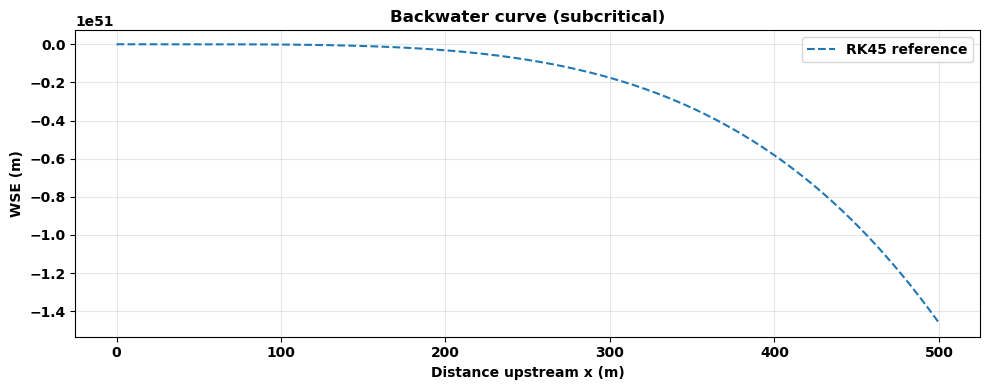

,h (m),wse (m)
x (m),,
0.0,7.000000e-01,7.000000e-01
0.5,6.325234e-01,6.330234e-01
1.0,5.939729e-01,5.949729e-01
1.5,5.625532e-01,5.640532e-01
2.0,5.347889e-01,5.367889e-01
...,...,...
498.0,-1.436991e+51,-1.436991e+51
498.5,-1.442929e+51,-1.442929e+51
499.0,-1.448885e+51,-1.448885e+51


In [147]:
from scipy.integrate import solve_ivp

def backwater_ode_ivp(x, h):
    """ODE for backwater equation: dh/dx = f(x, h)"""
    return backwater_rhs(h)

# For subcritical flow, integrate forward from downstream BC at x=0
x_span = [0, L]
h0 = [h_downstream]

# Solve the IVP (forward integration for subcritical flow from downstream)
sol = solve_ivp(backwater_ode_ivp, x_span, h0, method='RK45', dense_output=True, rtol=1e-8, atol=1e-10)

# Evaluate on fine grid
x_ref = np.linspace(0, L, 1001)
h_ref = sol.sol(x_ref)[0]
y_channel = x_ref*S0
wse_ref = h_ref + y_channel

print(f"Reference solution computed (IVP - subcritical flow):")
print(f"  Depth at x=0 (downstream): h = {h_ref[0]:.4f} m (BC: {h_downstream:.4f} m)")
print(f"  Depth at x=L (upstream): h = {h_ref[-1]:.4f} m")
print(f"  Fr at downstream: {compute_froude_number(h_ref[0]):.3f}")
print(f"  Fr at upstream: {compute_froude_number(h_ref[-1]):.3f}")

plt.figure(figsize=(10, 4))
plt.plot(x_ref, wse_ref, '--', label='RK45 reference')
plt.xlabel('Distance upstream x (m)')
plt.ylabel('WSE (m)')
plt.title('Backwater curve (subcritical)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

results = pd.DataFrame({'h (m)': h_ref, 'wse (m)': wse_ref}, index=pd.Index(x_ref, name='x (m)'))
display(results)

### Define Hydraulic Functions for PyTorch

Need tensor-compatible versions of the hydraulic functions for automatic differentiation.

In [148]:
# Tensor-compatible hydraulic functions (PyTorch)
_sqrt1pm2 = float(np.sqrt(1.0 + m**2))

def compute_area_torch(h):
    """Cross-sectional area (torch)."""
    h_pos = torch.clamp(h, min=1e-10)
    return h_pos * (b + m * h_pos)

def compute_wetted_perimeter_torch(h):
    """Wetted perimeter (torch)."""
    h_pos =  torch.clamp(h, min=1e-10)
    return b + 2.0 * h_pos * _sqrt1pm2

def compute_hydraulic_radius_torch(h):
    """Hydraulic radius (torch)."""
    A = compute_area_torch(h)
    P = compute_wetted_perimeter_torch(h)
    return A / P

def compute_top_width_torch(h):
    """Top width (torch)."""
    h_pos = torch.clamp(h, 1e-10)
    return b + 2.0 * m * h_pos

def compute_friction_slope_torch(h):
    """Friction slope from Manning (torch)."""
    A = compute_area_torch(h)
    R = compute_hydraulic_radius_torch(h)
    return (n**2 * Q**2) / (A**2 * R**(4.0 / 3.0))

def compute_froude_number_torch(h):
    """Froude number (torch)."""
    A = compute_area_torch(h)
    T = compute_top_width_torch(h)
    V = Q / A
    D = A / T
    return V / torch.sqrt(g * D)

def backwater_rhs_torch(h):
    """RHS for x increasing upstream: dh/dx = (Sf - S0) / (1 - Fr^2)."""
    Sf = compute_friction_slope_torch(h)
    Fr = compute_froude_number_torch(h)
    denom = 1.0 - Fr**2
    # Avoid singularity if the network wanders toward critical flow during early training
    eps = 1e-8
    denom_sign = torch.where(denom >= 0.0, torch.ones_like(denom), -torch.ones_like(denom))
    denom_safe = torch.where(torch.abs(denom) < eps, denom_sign * eps, denom)
    return (Sf - S0) / denom_safe

print("PyTorch hydraulic functions defined.")

PyTorch hydraulic functions defined.


### Define the Neural Network Architecture

The network consists of:
- Input layer: 1 input (x position)
- 6 hidden layers with 32 neurons each
- tanh activation functions
- Output layer: 1 output (h depth)

In [149]:
class PINN(nn.Module):
    def __init__(self, num_hidden=6, hidden_size=48):
        super(PINN, self).__init__()
        
        # Build the network
        layers = []
        layers.append(nn.Linear(1, hidden_size))
        layers.append(nn.Tanh())
        
        for _ in range(num_hidden - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_size, 1))
        
        self.network = nn.Sequential(*layers)
        
        # Use double precision for better accuracy
        self.double()
    
    def forward(self, x):
        return self.network(x)

# Initialize the network and move to device
net = PINN(num_hidden=6, hidden_size=32).to(device)
print(net)
print(f"\nModel is on: {next(net.parameters()).device}")

PINN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): Tanh()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Model is on: cpu


### Training setup
- Collocation points in $x\in[0,L]$
- One downstream boundary point: $h(0)=h_{ds}$ (subcritical)

In [150]:
# Boundary condition (subcritical flow): prescribe depth at downstream end x=0
# We scale the network input to x_hat = x/L in [0,1] for better training stability.
X_bc = torch.tensor([[0.0]], dtype=torch.float64, device=device)  # x_hat=0
H_bc = torch.tensor([[h_downstream]], dtype=torch.float64, device=device)

# Internal collocation points along the reach (x_hat in [0,1])
num_internal_points = 1000
x_internal = np.random.rand(num_internal_points) * L
xhat_internal = x_internal / L
X_internal = torch.tensor(xhat_internal, dtype=torch.float64, device=device).reshape(-1, 1)
X_internal.requires_grad_(True)

print(f"Internal collocation points: {num_internal_points}")
print(f"Boundary condition points: {len(X_bc)} (downstream at x_hat=0)")

Internal collocation points: 1000
Boundary condition points: 1 (downstream at x_hat=0)


### Loss
We minimize a weighted sum of:
- ODE residual: $h_x - \frac{S_f(h)-S_0}{1-Fr(h)^2}$
- Downstream boundary condition: $h(0)=h_{ds}$


In [151]:
def depth_from_raw(h_raw: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.softplus(h_raw) + 1e-6

def compute_loss(net, X_int, X_bc, H_bc, w_bc=1.0):
    """Compute PINN loss for backwater ODE with downstream BC (subcritical).
    
    The network input is x_hat = x/L in [0,1]. By chain rule:
      dh/dx = (1/L) * dh/dx_hat
    Residual enforces: dh/dx - (Sf - S0)/(1 - Fr^2) = 0.
    """
    h_raw = net(X_int)
    h = depth_from_raw(h_raw)

    h_xhat = torch.autograd.grad(
        outputs=h,
        inputs=X_int,
        grad_outputs=torch.ones_like(h),
        create_graph=True,
    )[0]
    h_x = h_xhat / L
    rhs = backwater_rhs_torch(h)
    residual = h_x - rhs
    mse_ode = torch.mean(residual**2)

    h_bc = depth_from_raw(net(X_bc))
    mse_bc = torch.mean((h_bc - H_bc)**2)

    loss = mse_ode + w_bc * mse_bc
    return loss, mse_ode, mse_bc

### Train the Network

Using L-BFGS (quasi-Newton) optimizer for better convergence.

In [ ]:
# Training parameters
num_iterations = 300

history = {'loss': [], 'mse_ode': [], 'mse_bc': []}

print("Training with L-BFGS optimizer...")
net.train()

optimizer = torch.optim.LBFGS(
    net.parameters(),
    lr=1.0,
    max_iter=20,
    line_search_fn="strong_wolfe",
    tolerance_grad=1e-10,
    tolerance_change=1e-12,
    history_size=100,
)

for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        loss, _, _ = compute_loss(net, X_internal, X_bc, H_bc)
        if not torch.isfinite(loss):
            return loss
        loss.backward()
        return loss
    
    optimizer.step(closure)
    loss, mse_ode, mse_bc = compute_loss(net, X_internal, X_bc, H_bc)
    if (not torch.isfinite(loss)) or (not torch.isfinite(mse_ode)) or (not torch.isfinite(mse_bc)):
        print(f"\nNon-finite detected at iteration {i}; stopping.")
        break
    
    history['loss'].append(loss.item())
    history['mse_ode'].append(mse_ode.item())
    history['mse_bc'].append(mse_bc.item())
    
    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6e}, MSE_ode = {mse_ode.item():.6e}, MSE_bc = {mse_bc.item():.6e}")

print(f"\nDone. Last loss: {history['loss'][-1]:.6e}")

Training with L-BFGS optimizer...
Iteration 0: Loss = 2.036415e-03, MSE_ode = 2.033222e-03, MSE_bc = 3.193328e-06
Iteration 50: Loss = 1.623184e-03, MSE_ode = 1.623184e-03, MSE_bc = 1.471006e-10
Iteration 100: Loss = 1.623182e-03, MSE_ode = 1.623182e-03, MSE_bc = 1.341733e-10


In [ ]:
x_test = np.linspace(0, L, 1001)
xhat_test = x_test / L
X_test_ = torch.tensor(xhat_test, dtype=torch.float64).reshape(-1, 1).to(device)

net.eval()
with torch.no_grad():
    h_pred = depth_from_raw(net(X_test_)).cpu().numpy().flatten()
wse_pred = h_pred + x_test*S0

results_pinn = pd.DataFrame({'h (m)': h_pred, 'wse (m)': wse_pred}, index=pd.Index(x_test, name='x (m)'))
display(results_pinn)

,h (m),wse (m)
x (m),,
0.0,0.700000,0.700000
0.5,0.703426,0.703926
1.0,0.706823,0.707823
1.5,0.710189,0.711689
2.0,0.713526,0.715526
...,...,...
498.0,1.254193,1.752193
498.5,1.254328,1.752828
499.0,1.254463,1.753463


### Compare PINN Solution with Reference

Error metrics:
  Relative L2 error: 0.004798
  Max abs error:     0.0147 m
  Mean abs error:    0.0039 m


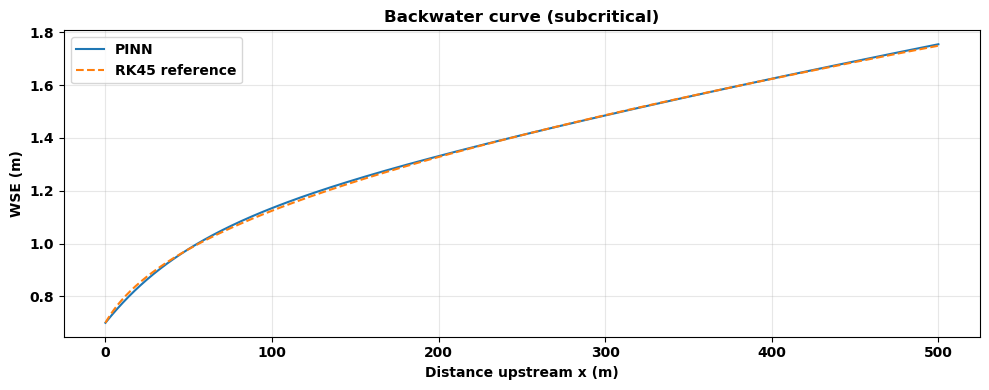

In [ ]:
# Error metrics
rel_error = np.linalg.norm(h_pred - h_ref) / np.linalg.norm(h_ref)
max_error = np.max(np.abs(h_pred - h_ref))
mean_error = np.mean(np.abs(h_pred - h_ref))

print("Error metrics:")
print(f"  Relative L2 error: {rel_error:.6f}")
print(f"  Max abs error:     {max_error:.4f} m")
print(f"  Mean abs error:    {mean_error:.4f} m")

plt.figure(figsize=(10, 4))
plt.plot(x_test, wse_pred, label='PINN')
plt.plot(x_ref, wse_ref, '--', label='RK45 reference')
plt.xlabel('Distance upstream x (m)')
plt.ylabel('WSE (m)')
plt.title('Backwater curve (subcritical)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()